<h1><center> ENSF 519.01 Applied Data Science </center></h1>
<h2><center> Final Project </center></h2>
<h3><center> Oscar Award Predictions</center></h3>
<p><center> Mark Ricalde, Paul Chen, Brian Pho, Harjee Johal <center></p>

# Phase 1

## Data Preprocessing

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def clean_text(text):
    #Lower casing the text
    text = text.lower()
    
    #Removing punctuation
    translation = text.maketrans("", "", string.punctuation)
    text = text.translate(translation)
    re.sub("\s\s+", " ", text)
    
    #Removing stop words
    text = " ".join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    
    #Stemming the words
    text = " ".join([stemmer.stem(word) for word in text.split()])

    return text


# Load dataset
data = pd.read_csv('oscar_data.csv') # TODO - Replace dummy csv with real merged csv

# Cleaning the script
data["script"] = data["script"].apply(clean_text)

# Features/Labels for classifying whether a movie will win an oscar
features_1 = data.loc[:, data.columns != 'winner']
labels_1   = data["winner"]

# Features/Labels for classifying what category a movie will be in
features_2 = data.loc[:, data.columns != 'category']
labels_2   = data["category"]
   
# Splitting the data set
xtrain, xtest, ytrain, ytest = train_test_split(features_1, labels_1, stratify=labels_1, test_size=0.2)

# Vectorizing the training set
# TODO - Only vectorize textual features
# tfidf_vect = TfidfVectorizer().fit(xtrain)
# xtrain     = tfidf_vect.transform(xtrain)


## Visualization and Exploratory Data Analysis

# Phase 2

## Discriminative Models

## Generative Models

## Clustering Models

## Machine Learning Models

## Movie Script RNN

### Get imports

In [1]:
# Common imports
import numpy as np
import pandas as pd
import tensorflow as tf

### Get data and labels

In [2]:
# Used to run on Google Colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
# Get scripts data
# script_csv_path = "/content/drive/My Drive/ENSF 519/Data/combined_script_data.csv"
script_csv_path = "./processed_data/script_data.csv"
script_data = pd.read_csv(script_csv_path)
script_data = script_data.drop(columns=["release_year"])
# display(script_data)

# Get Oscar labels
# oscar_labels_path = "/content/drive/My Drive/ENSF 519/Data/oscar_data.csv"
oscar_labels_path = "./processed_data/oscar_data.csv"
oscar_label = pd.read_csv(oscar_labels_path).rename(columns={"entity": "title", "category": "nominated", "winner": "won"})
oscar_label = oscar_label.drop(columns=["year"])
oscar_label["nominated"] = True
# display(oscar_label)

# Merge script and Oscar data
script_oscar_df = pd.merge(script_data, oscar_label, how="outer", on="title")
script_oscar_df = script_oscar_df.dropna(subset=['script'])
script_oscar_df = script_oscar_df.fillna(False)
# display(script_oscar_df)

script_oscar_df['nominated'].astype('bool')
script_oscar_df['won'].astype('bool')
# print(script_oscar_df.dtypes)
# display(script_oscar_df)

# Only choose movies that were nominated and won
script_oscar_df = script_oscar_df[script_oscar_df['nominated'] == script_oscar_df['won']].drop_duplicates()
script_oscar_df = script_oscar_df.drop(columns=['nominated'])
script_oscar_df['won'] = script_oscar_df['won'].astype(int)
script_oscar_df = script_oscar_df.reset_index(drop=True)

display(script_oscar_df)

,title,script,won
0,When Worlds Collide,"['needl', 'heaven', 'haystack', 'star', 'heave...",1
1,Reds,"['rememb', 'im', 'begin', 'forget', 'peopl', '...",1
2,Undefeated,"['let', 'start', 'right', 'guard', 'shot', 'lo...",1
3,Seven Brides for Seven Brothers,"['deliv', 'perfectionand', 'dont', 'brag', 'd'...",1
4,Henry V,"['oh', 'muse', 'ascend', 'brightest', 'heaven'...",1
...,...,...,...
3195,The Roommate,"['hi', 'hi', 'sara', 'matthew', 'sara', 'matth...",0
3196,Night of the Comet,"['record', 'time', 'swung', 'univers', 'ellipt...",0
3197,Paddington,"['darkest', 'peru', 'vast', 'unexplor', 'wilde...",0
3198,Jumanji: Welcome to the Jungle,"['ocean', 'wave', 'crash', 'seagul', 'squawk',...",0


### Preprocess data for RNN

In [8]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

vocab_size = 10000  # Max number of words to consider
max_len = 13000  # Max script length (in words)
seed = 0

# One-Hot encode the script
script_oscar_df['one_hot_script'] = script_oscar_df['script'].apply(one_hot, n=vocab_size)
# display(script_oscar_df)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(script_oscar_df['one_hot_script'], script_oscar_df['won'], random_state=seed)

# Pad scripts
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, max_len)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Calculate class imbalance
unique, counts = np.unique(script_oscar_df['won'], return_counts=True)
class_weights = {0: 1, 1: counts[0] / counts[1]}  # Give one class a baseline of one, calculate how many times the other class if off by
print("Class weights:", class_weights)

Class weights: {0: 1, 1: 4.194805194805195}


In [9]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train))
print(type(y_train))

(2400, 13000)
(2400,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Create Simple RNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(SimpleRNN(32, kernel_regularizer=None, recurrent_regularizer=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

### Train Simple RNN model

In [ ]:
simple_rnn_history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1, class_weight=class_weights)

### Plot results

In [112]:
import matplotlib.pyplot as plt

def plot_results(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')

    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
plot_results(simple_rnn_history)

### Test model

In [19]:
test_loss, metric_loss = model.evaluate(X_test, y_test, batch_size=32, verbose=1)

### Display confusion matrix

In [147]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
y_pred = model.predict(X_test, batch_size=32).round()
plot_confusion_matrix(y_test, y_pred)
plt.show()

## IMDB DNN

### Get data and labels

In [149]:
# Get IMDB movie metadata
# script_csv_path = "/content/drive/My Drive/ENSF 519/Data/combined_imdb_data.csv"
imdb_csv_path = "./processed_data/combined_imdb_data.csv"
imdb_data = pd.read_csv(imdb_csv_path, index_col=0).rename(columns={"Title": "title"})

# Preprocess the data into numerical values
imdb_data = imdb_data[imdb_data['Response'] == True]
imdb_data = imdb_data[['title', 'BoxOffice', 'Metascore', 'Runtime', 'Year', 'imdbRating', 'imdbVotes']]
# Box Office
imdb_data['BoxOffice'] = imdb_data['BoxOffice'].str.replace(r'[\$\,]', "")
imdb_data['BoxOffice'] = imdb_data['BoxOffice'].str.replace(r'', "0")
imdb_data = imdb_data.fillna(0)
imdb_data['BoxOffice'] = imdb_data['BoxOffice'].astype(float)
# Metascore
imdb_data['Metascore'] = imdb_data['Metascore'].astype(float)
# Runtime
imdb_data['Runtime'] = imdb_data['Runtime'].str.replace(r' min', "")
imdb_data['Runtime'] = imdb_data['Runtime'].astype(float)
# Year
imdb_data['Year'] = imdb_data['Year'].str.replace('(\–\d*)', "")
imdb_data['Year'] = imdb_data['Year'].astype(float)
# IMDb Votes
imdb_data['imdbVotes'] = imdb_data['imdbVotes'].str.replace(',', "")
imdb_data['imdbVotes'] = imdb_data['imdbVotes'].astype(float)
# print(imdb_data.dtypes)
# display(imdb_data)

# Get Oscar labels
# oscar_labels_path = "/content/drive/My Drive/ENSF 519/Data/oscar_data.csv"
oscar_labels_path = "./processed_data/oscar_data.csv"
oscar_label = pd.read_csv(oscar_labels_path).rename(columns={"entity": "title", "category": "nominated", "winner": "won"})
oscar_label = oscar_label.drop(columns=["year"])
oscar_label["nominated"] = True
# display(oscar_label)

# Merge script and Oscar data
imdb_oscar_df = pd.merge(imdb_data, oscar_label, how="outer", on="title")
imdb_oscar_df = imdb_oscar_df.dropna(subset=['BoxOffice'])
imdb_oscar_df = imdb_oscar_df.fillna(False)
imdb_oscar_df['nominated'].astype('bool')
imdb_oscar_df['won'].astype('bool')

# Only choose movies that were nominated and won
imdb_oscar_df = imdb_oscar_df[imdb_oscar_df['nominated'] == imdb_oscar_df['won']].drop_duplicates()
imdb_oscar_df = imdb_oscar_df.drop(columns=['nominated', 'title'])
imdb_oscar_df['won'] = imdb_oscar_df['won'].astype(int)
imdb_oscar_df = imdb_oscar_df.reset_index(drop=True)

display(imdb_oscar_df)

,BoxOffice,Metascore,Runtime,Year,imdbRating,imdbVotes,won
0,0.000000e+00,0.0,30,2009.0,7.8,41,0
1,0.000000e+00,54.0,106,1987.0,6.7,29262,0
2,5.090408e+15,76.0,103,2016.0,7.2,267933,0
3,0.000000e+00,70.0,97,1999.0,7.3,275872,0
4,0.000000e+00,12.0,101,1983.0,6.3,6022,0
...,...,...,...,...,...,...,...
4260,3.040102e+17,78.0,108,2016.0,8.0,394091,1
4261,0.000000e+00,0.0,142,1964.0,7.7,19035,1
4262,0.000000e+00,0.0,104,1972.0,7.2,4442,0
4263,0.000000e+00,0.0,98,1958.0,6.5,2114,0


### Preprocess data for DNN

In [105]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

seed = 0
labels = imdb_oscar_df['won']
data = imdb_oscar_df.drop(columns=['won'])

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=seed)

# Normalize the input
normalizer = Normalizer().fit(X_train)
X_train = normalizer.transform(X_train)
X_test = normalizer.transform(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Calculate class imbalance
unique, counts = np.unique(labels, return_counts=True)
class_weights = {0: 1, 1: counts[0] / counts[1]}  # Give one class a baseline of one, calculate how many times the other class if off by
print("Class weights:", class_weights)

Class weights: {0: 1, 1: 3.5810955961331903}


In [106]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train))
print(type(y_train))

(3198, 6)
(3198,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Create DNN model

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Dense(32, input_shape=(6,)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 32)                224       
_________________________________________________________________
dropout_68 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
dense_94 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_69 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_70 (Dropout)         (None, 256)             

### Train DNN model

In [145]:
dnn_history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_split=0.2, verbose=1, class_weight=class_weights)

Train on 2558 samples, validate on 640 samples
Epoch 1/15
2558/2558 [==============================] - 2s 785us/sample - loss: 1.7131 - acc: 0.5133 - val_loss: 1.0248 - val_acc: 0.4547
Epoch 2/15
2558/2558 [==============================] - 1s 290us/sample - loss: 1.4390 - acc: 0.5332 - val_loss: 1.0116 - val_acc: 0.7125
Epoch 3/15
2558/2558 [==============================] - 1s 267us/sample - loss: 1.3328 - acc: 0.5352 - val_loss: 1.0124 - val_acc: 0.4547
Epoch 4/15
2558/2558 [==============================] - 1s 285us/sample - loss: 1.2690 - acc: 0.5172 - val_loss: 1.0113 - val_acc: 0.5359
Epoch 5/15
2558/2558 [==============================] - 1s 273us/sample - loss: 1.1559 - acc: 0.5235 - val_loss: 1.0107 - val_acc: 0.6141
Epoch 6/15
2558/2558 [==============================] - 1s 272us/sample - loss: 1.1709 - acc: 0.5250 - val_loss: 1.0065 - val_acc: 0.5219
Epoch 7/15
2558/2558 [==============================] - 1s 266us/sample - loss: 1.1419 - acc: 0.5180 - val_loss: 1.0096 - val

### Plot results, Test model, Display confusion matrix

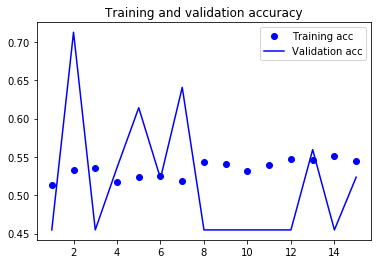

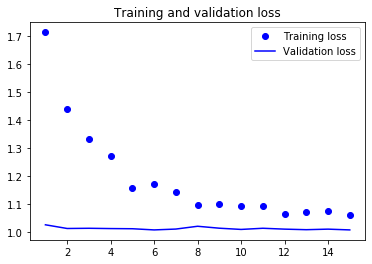

0.6674609807125296 0.5164011
[[390 444]
 [ 72 161]]


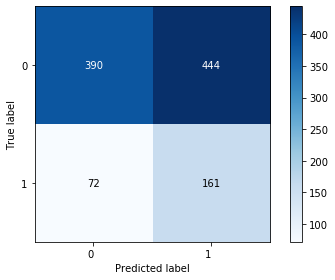

In [148]:
plot_results(dnn_history)
test_loss, metric_loss = model.evaluate(X_test, y_test, batch_size=32, verbose=1)
print(test_loss, metric_loss)

y_pred = model.predict(X_test, batch_size=32).round()
plot_confusion_matrix(y_test, y_pred)
plt.show()